# Assignment 2


#### 1. 复习上课内容以及复现课程代码

在本部分，你需要在复习上课内容和课程代码后，复现课程代码。 

#### 2. 回答以下理论题目

###### 2.1 What conditions are required to make the BFS return the optimal solution ?

There are two conditions:
- All costs between two nodes are positive or zero.
- Sort the list used to maintain the searching history in every iteration

##### 2.2 Is there a way to make DFS find the optimal solution ? (You may need to read some material about iterative DFS)

Yes, I believe there are two methods:
- record all possible paths and compare them after searching end
- using Iterative DFS

Iterative DFS: Limit depth for all paths of DFS. If goal isn't in the depth, extend depth for searching.

In [1]:
# A simple example code for IDFS

def idfs(max_depth, root, goal):
    # if path not in depth_i, search in depth_i+1
    for depth in range(1, max_depth+1):
        found = dfs(depth, root, goal)
        if found == goal: return found
    return None

def dfs(depth, node, goal):
    if depth == 0 or node == goal:
        return node
    else:
        for child in graph(node):
            return dfs(depth-1, child, goal)

##### 2.3 In what conditions BFS is a better choice than DFS and vice versa ?

- BFS is better when speed is more important than memory usage. If conditions are satisfied, BFS can reach the optional solution.
- DFS is slow, but it uses backtracking so that using less storage. 

##### 2.4 When can we use machine learning ?

- There is a model, or performance that we can keep improving
- The model, or rules are not easy to define (at least not easy for human)
- Enough data

##### 2.5 What is the gradient of a function ?

Gradient is the direction that makes directional derivative maximum. Gradient direction of the function is the direction that function has the fastest change.

##### 2.6 How can we find the maximum value of a function using the information of gradient ?

- If the function doesn't has local optimal, follow the positive direction of gradient till gradient equals zero
- Else, sometimes we can only find the local maximum value instead of global optimal. Maybe try with several different random start will help.

#### 3. 实践部分  寻找地铁路线

In this part, although we recommend you to use Beijing subway, you still can use the subway map of any cities that you are interested in. 

![title](img/ditu.png)

Please using the search policy to implement an agent. This agent receives two input, one is @param start station and the other is @param destination. Your agent should give the optimal route based on Beijing Subway system.

Deadline: 2019-October-27

#### Procedures

#### 1. Get data from web.  

Some tips: 

a. You might need this package: requests[https://2.python-requests.org/en/master/] to get webpages

b.You might need to use Regular Expression and Beautiful Soap package to parse the webpages

In [2]:
# Shanghai Subway
# Source data from http://map.amap.com/subway/index.html?&1100 -- json data
import requests
import json

def get_page(url, headers):
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.text
        else:
            print('Request failed', response.status_code)
    except requests.exceptions.ConnectionError as e:
        print('Error', e.args)

# since we only need to get data once, there is no need for agent
url = 'http://map.amap.com/service/subway?_1571974190637&srhdata=3100_drw_shanghai.json'
headers = {
    'Host': 'map.amap.com',
    'Accept-Encoding': 'gzip, deflate',
    'Accept-Language': 'en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7'
}

page = get_page(url, headers)
page_json = json.loads(page)

In [3]:
page_json

{'s': '上海市地铁',
 'i': '3100',
 'l': [{'st': [{'rs': '650 1137|650 1137',
     'udpx': ';',
     'su': '1',
     'udsu': '1;1',
     'n': '莘庄',
     'sid': '310100025685029',
     'p': '650 1137',
     'r': '310100025685|900000059516',
     'udsi': '310100025686002;310100025685029',
     't': '1',
     'si': '310100025685029',
     'sl': '121.385373,31.111152',
     'udli': '310100025686;310100025685',
     'poiid': 'BV10025001',
     'lg': '3',
     'sp': 'XinZhuang'},
    {'rs': '681 1111',
     'udpx': ';',
     'su': '1',
     'udsu': '1;1',
     'n': '外环路',
     'sid': '310100025685028',
     'p': '681 1111',
     'r': '310100025685',
     'udsi': '310100025686003;310100025685028',
     't': '0',
     'si': '310100025685028',
     'sl': '121.393020,31.120899',
     'udli': '310100025686;310100025685',
     'poiid': 'BV10039895',
     'lg': '6',
     'sp': 'WaiHuan Lu'},
    {'rs': '702 1091',
     'udpx': ';',
     'su': '1',
     'udsu': '1;1',
     'n': '莲花路',
     'sid': '3101000

##### 2. Preprocessing data

Some tips:

a. Find a suitable way to save the data you get from the web. (Note: The way you use to save the data should be able to be used to create the graph that your agent is going to explore)

In [4]:
# extract stations data from json file
def subway_map(file):
    st_dict = dict() # initialize stations dict
    lines_dict = dict() # initialize subway lines dict
    for st_line in file['l']:
        line_name = st_line['ln']  # subway_line' name e.g.一号线
        sts = st_line['st']        # stations of the line
        lines_dict[line_name] = list()
        
        for i, st in enumerate(sts):
            # stations at begin and end only has one neighbor
            if i != 0:
                pre_st = sts[i-1]['n']
            else:
                pre_st = ''
            if i != len(sts) - 1:
                next_st = sts[i+1]['n']
            else:
                next_st = ''
            
            cur_st = st['n']                                 # statiom name e.g.上海火车站
            st_loc = list(map(float, tuple(st['sl'].split(','))))   # station location (longitude, latitude)
            
            # store the data to lines dict
            lines_dict[line_name].append(cur_st)
            # store the data to stations dict
            if cur_st in st_dict:
                if pre_st:
                    st_dict[cur_st]['neighbor'].add(pre_st)
                if next_st:
                    st_dict[cur_st]['neighbor'].add(next_st)
            else:
                st_dict[cur_st] = {'line': line_name,
                                   'loc': st_loc,
                                   'neighbor': set(neighbor for neighbor in [pre_st, next_st] if neighbor)
                                  }
    return st_dict, lines_dict
            
            

In [5]:
stations, lines = subway_map(page_json)

In [6]:
stations

{'莘庄': {'line': '1号线',
  'loc': [121.385373, 31.111152],
  'neighbor': {'外环路', '春申路'}},
 '外环路': {'line': '1号线',
  'loc': [121.39302, 31.120899],
  'neighbor': {'莘庄', '莲花路'}},
 '莲花路': {'line': '1号线',
  'loc': [121.40291, 31.1309],
  'neighbor': {'外环路', '锦江乐园'}},
 '锦江乐园': {'line': '1号线',
  'loc': [121.414107, 31.142217],
  'neighbor': {'上海南站', '莲花路'}},
 '上海南站': {'line': '1号线',
  'loc': [121.430041, 31.154579],
  'neighbor': {'漕宝路', '石龙路', '锦江乐园'}},
 '漕宝路': {'line': '1号线',
  'loc': [121.433143, 31.168344],
  'neighbor': {'上海体育馆', '上海南站', '桂林公园', '龙漕路'}},
 '上海体育馆': {'line': '1号线',
  'loc': [121.437423, 31.182813],
  'neighbor': {'上海体育场', '徐家汇', '漕宝路'}},
 '徐家汇': {'line': '1号线',
  'loc': [121.436837, 31.195338],
  'neighbor': {'上海体育馆', '上海游泳馆', '交通大学', '宜山路', '肇嘉浜路', '衡山路'}},
 '衡山路': {'line': '1号线',
  'loc': [121.446424, 31.204528],
  'neighbor': {'常熟路', '徐家汇'}},
 '常熟路': {'line': '1号线',
  'loc': [121.449141, 31.213524],
  'neighbor': {'肇嘉浜路', '衡山路', '陕西南路', '静安寺'}},
 '陕西南路': {'line': '1号线',


In [7]:
lines

{'1号线': ['莘庄',
  '外环路',
  '莲花路',
  '锦江乐园',
  '上海南站',
  '漕宝路',
  '上海体育馆',
  '徐家汇',
  '衡山路',
  '常熟路',
  '陕西南路',
  '黄陂南路',
  '人民广场',
  '新闸路',
  '汉中路',
  '上海火车站',
  '中山北路',
  '延长路',
  '上海马戏城',
  '汶水路',
  '彭浦新村',
  '共康路',
  '通河新村',
  '呼兰路',
  '共富新村',
  '宝安公路',
  '友谊西路',
  '富锦路'],
 '2号线': ['浦东国际机场',
  '海天三路',
  '远东大道',
  '凌空路',
  '川沙',
  '华夏东路',
  '创新中路',
  '唐镇',
  '广兰路',
  '金科路',
  '张江高科',
  '龙阳路',
  '世纪公园',
  '上海科技馆',
  '世纪大道',
  '东昌路',
  '陆家嘴',
  '南京东路',
  '人民广场',
  '南京西路',
  '静安寺',
  '江苏路',
  '中山公园',
  '娄山关路',
  '威宁路',
  '北新泾',
  '淞虹路',
  '虹桥2号航站楼',
  '虹桥火车站',
  '徐泾东'],
 '3号线': ['江杨北路',
  '铁力路',
  '友谊路',
  '宝杨路',
  '水产路',
  '淞滨路',
  '张华浜',
  '淞发路',
  '长江南路',
  '殷高西路',
  '江湾镇',
  '大柏树',
  '赤峰路',
  '虹口足球场',
  '东宝兴路',
  '宝山路',
  '上海火车站',
  '中潭路',
  '镇坪路',
  '曹杨路',
  '金沙江路',
  '中山公园',
  '延安西路',
  '虹桥路',
  '宜山路',
  '漕溪路',
  '龙漕路',
  '石龙路',
  '上海南站'],
 '4号线': ['宜山路',
  '虹桥路',
  '延安西路',
  '中山公园',
  '金沙江路',
  '曹杨路',
  '镇坪路',
  '中潭路',
  '上海火车站',
  '宝山路',
  '海伦路',
  '临平路',
  '大连路',
  '杨树浦路',
  '浦东

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [32]:
# make map colorful. Transfer stations' color is black
color_map = {'1号线': 'brown',
             '2号线': 'red',
             '3号线': 'coral',
             '4号线': 'gold',
             '5号线': 'darkkhaki',
             '6号线': 'olive',
             '7号线': 'olivedrab',
             '8号线': 'palegreen',
             '9号线': 'turquoise',
             '10号线': 'teal',
             '11号线': 'c',
             '12号线': 'deepskyblue',
             '13号线': 'steelblue',
             '16号线': 'royalblue',
             '17号线': 'midnightblue',
             '磁悬浮': 'blueviolet',
             '浦江线': 'purple',
             '换乘站': 'black'
            }
def get_color(station, stations):
    if is_transfer_st(station):
        return color_map['换乘站']
    else:
        return color_map[stations[station]['line']]

def is_transfer_st(station):
    count = 0
    for line in lines.keys():
        if station in lines[line]:
            count += 1
    if count > 1: return True
    else: return False

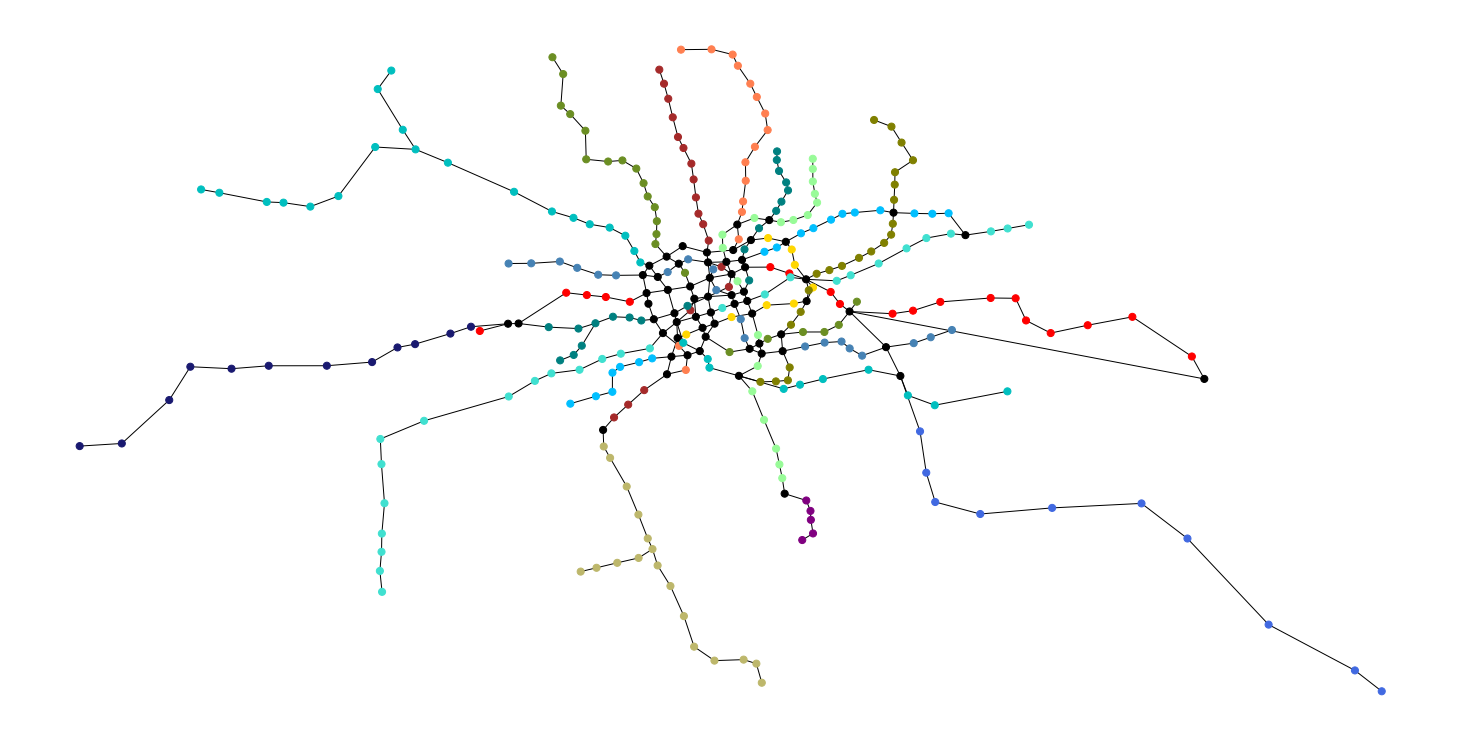

In [33]:
test_graph = nx.Graph({st: stations[st]['neighbor'] for st in stations.keys()})
test_graph.add_nodes_from(list(stations.keys()))
nx.draw(test_graph, {st: stations[st]['loc'] for st in stations.keys()}, 
        node_color=[get_color(st, stations) for st in stations.keys()], with_labels=False, node_size=50)

#### 3. Build the search agent

Build the search agent based ont he graph you built.

for example, if you use Beijing subway graoh, and you run:

\>>> search("奥体中心“，”天安门“）

You should get the result as follows: 奥体中心 -> A ->B ->C ... -> 天安门

In [34]:
# stations' neighbor graph
neighbor_graph = {st: stations[st]['neighbor'] for st in stations.keys()}

# search_agent
def search_agent(departure, arrival, search_method, graph=neighbor_graph, search_strategy=lambda x:x, show_graph=True):
    path = search_method(graph, departure, arrival, search_strategy)
    if departure not in graph or arrival not in graph:
        print('Input error.')
    
    if path:
        if show_graph:
            draw_path(path)
        print('The best path is ' + '->'.join(path))

# draw the path
def draw_path(path):
    path_graph = nx.DiGraph({path[i]: [path[i+1]] for i in range(len(path) - 1)})
    path_graph.add_nodes_from(path)
    nx.draw(path_graph, {st: stations[st]['loc'] for st in path}, 
            node_color = [get_color(st, stations) for st in path], 
            with_labels=True, node_size=100, width=5, font_size=20, alpha=0.7， figsize=(10, 5))
def move_loc(l):
    return [l[0], l[1] * 0.9]

SyntaxError: invalid character in identifier (<ipython-input-34-0a5034d3c18e>, line 21)

In [35]:
# search_method

# bfs
def optimal_search(graph, start, destination, search_strategy):
    paths = [[start]]
    visited = set()
    while paths:
        path = paths.pop(0)
        froniter = path[-1]
        
        for city in graph[froniter]:
            if city in visited: continue
            
            new_path = path + [city]
            
            paths.append(new_path)

        paths = search_strategy(paths)
        visited.add(froniter)
        if paths and paths[0][-1] == destination:
            return paths[0]
    return []

# dfs

def dfs(graph, start, destination, search_strategy):
    paths = [[start]]
    visited = set()
    while paths:
        path = paths.pop(0)
        froniter = path[-1]
        
        for city in graph[froniter]:
            if city in visited: continue
            
            new_path = path + [city]
            
            paths = [new_path] + paths

        paths = search_strategy(paths)
        visited.add(froniter)
        if paths and paths[0][-1] == destination:
            return paths[0]
    return []

The best path is 上海火车站->汉中路->南京西路->陕西南路->上海图书馆->交通大学->徐家汇->上海体育馆->漕宝路->上海南站


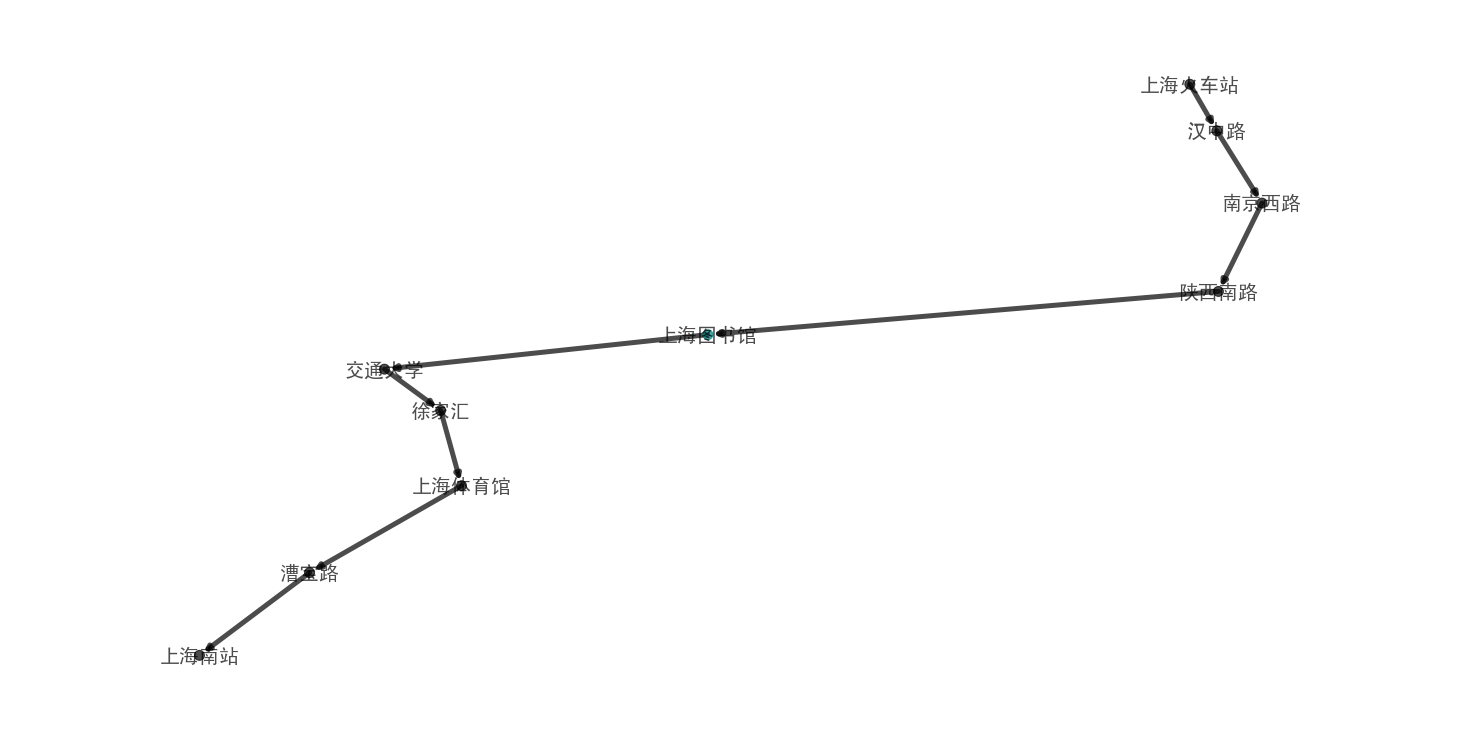

In [36]:
# test without strategies
search_agent('上海火车站', '上海南站', optimal_search)

The best path is 上海火车站->汉中路->自然博物馆->南京西路->静安寺->常熟路->衡山路->徐家汇->肇嘉浜路->嘉善路->大木桥路->龙华中路->后滩->长清路->耀华路->中华艺术宫->西藏南路->南浦大桥->塘桥->蓝村路->浦电路(4号线)->世纪大道->浦东大道->杨树浦路->大连路->临平路->海伦路->邮电新村->四平路->曲阳路->虹口足球场->西藏北路->中兴路->曲阜路->人民广场->大世界->老西门->陆家浜路->马当路->新天地->陕西南路->上海图书馆->交通大学->江苏路->中山公园->延安西路->虹桥路->宜山路->漕溪路->龙漕路->石龙路->上海南站


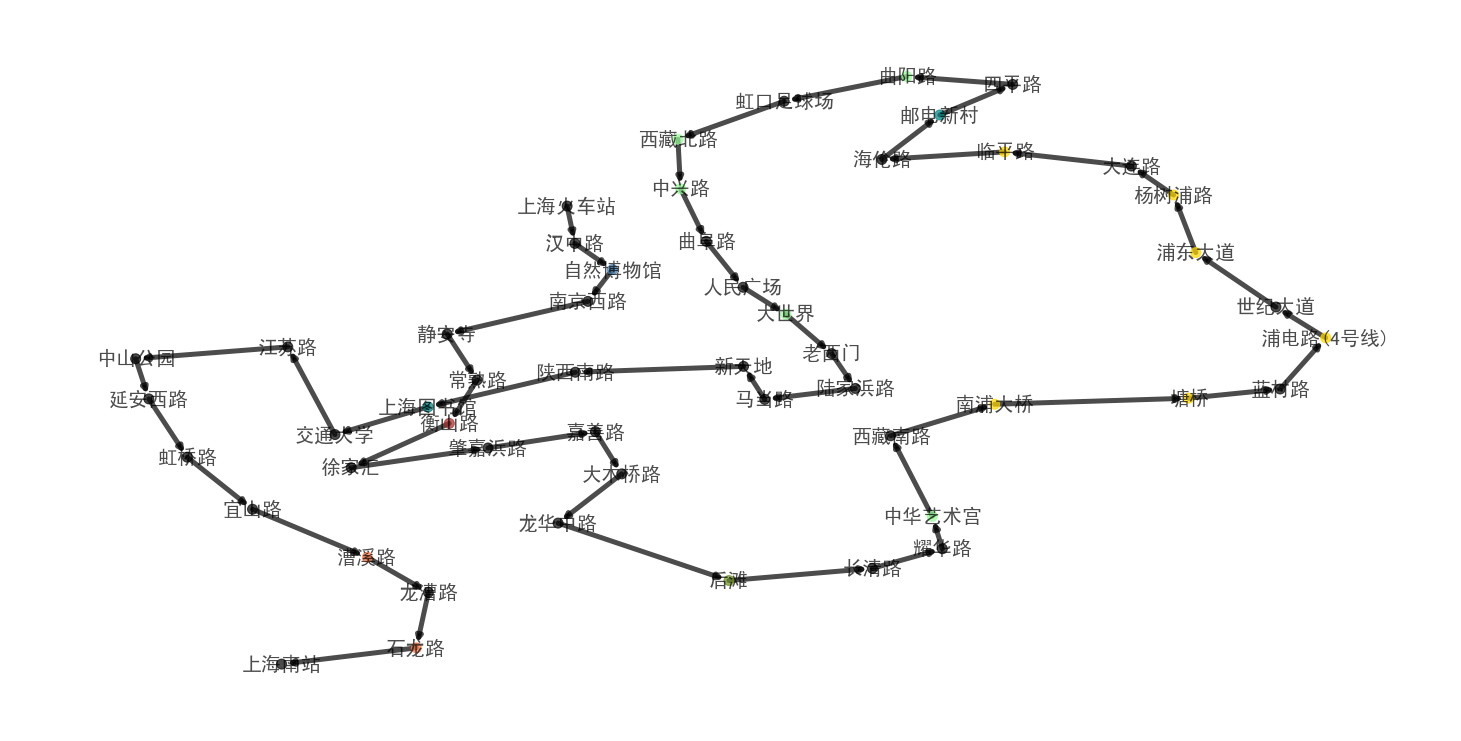

In [37]:
search_agent('上海火车站', '上海南站', dfs)

### (Optional) Improve your agent to make it able to find a path based on different strategies

Some ideas you might want to try:

a. Find the shortest path between two stations.

b. Find the path that requires minimum transfers between two stations.

c. Combine the previous two ideas, find a more suitable path.

Compare your results with results obtained by using some apps such as Baidu map, A map, Google map or Apple map. If there is difference, try to explanate it.

#### strategy 1 ----> minimum transfers (transfer means from one line to another)

In [38]:
def mini_transfer(paths):
    def n_transfer(path):
        count = 0
        # for every node (except first and end), if the pre_node and next_node in different line, transfer happens
        for i in range(1, len(path)-1):
            if is_same_line(path[i-1], path[i+1]):
                continue
            else:
                count += 1
        return count
    return sorted(paths, key=n_transfer)
def is_same_line(pre_node, next_node):
    pre_line = set([l for l in lines.keys() if pre_node in lines[l]])
    next_line = set([l for l in lines.keys() if next_node in lines[l]])
        
    return pre_line & next_line

Minimum statios:
The best path is 上海火车站->汉中路->南京西路->陕西南路->上海图书馆->交通大学->徐家汇->上海体育馆->漕宝路->上海南站

Minimum transfers
The best path is 上海火车站->汉中路->新闸路->人民广场->黄陂南路->陕西南路->常熟路->衡山路->徐家汇->上海体育馆->漕宝路->上海南站


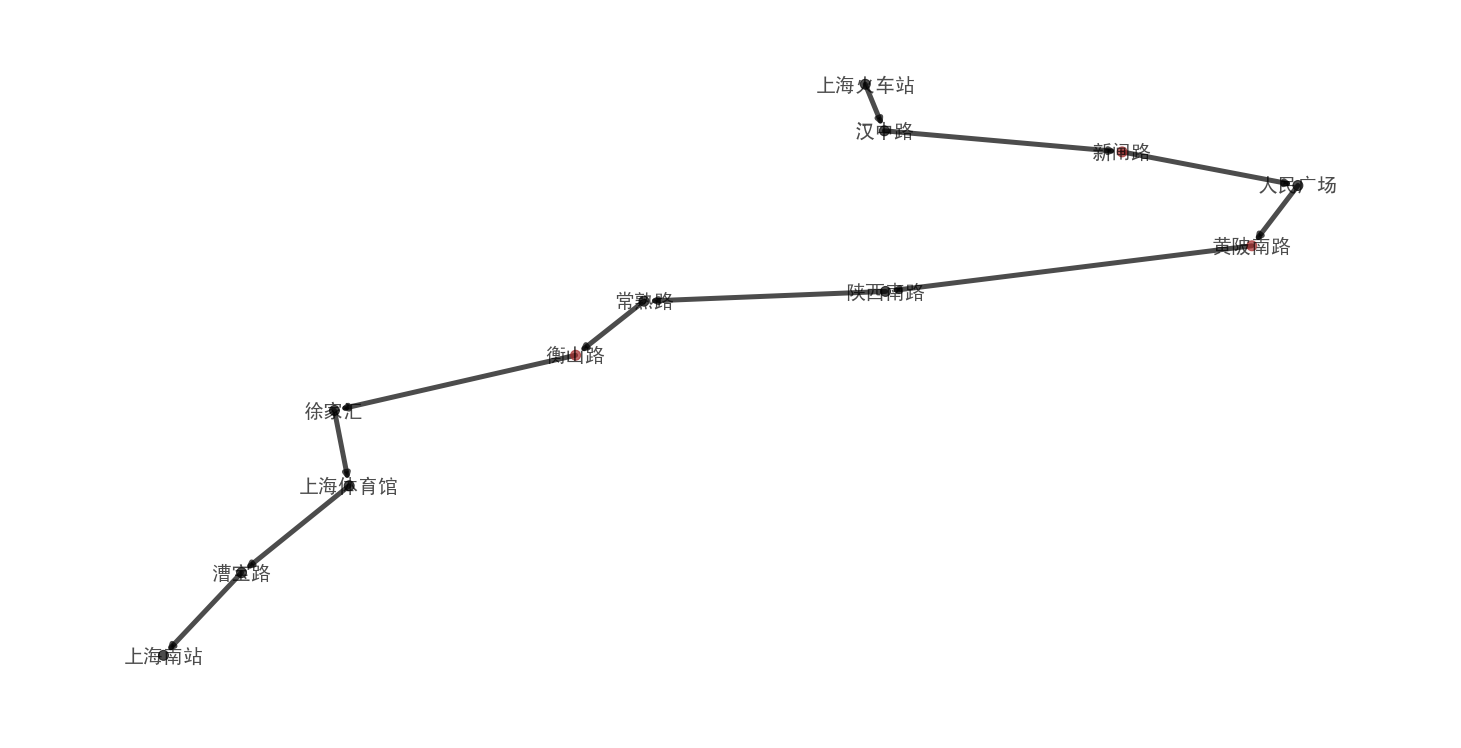

In [39]:
print('Minimum statios:')
search_agent('上海火车站', '上海南站', optimal_search, show_graph=False)
print()
print('Minimum transfers')
search_agent('上海火车站', '上海南站', optimal_search, search_strategy=mini_transfer)

#### strategy 2 ---> minimum time cost

In [40]:
# calculate the distance
import math

def loc_distance(begin, destination):
    """
    Calculate the Haversine distance.
    
    Parameters:
    begin: tuple of float (long, lat)
    destination: tuple of float (long, lat)
    
    Returns: distance in km: float
    """
    rlong1, rlat1 = map(math.radians, begin) #角度转换为弧度
    rlong2, rlat2 = map(math.radians, destination)
    radius = 6371 # km
    
    d = radius * math.acos(math.cos(rlat1) * math.cos(rlat2) * math.cos(rlong1 - rlong2) + 
                  math.sin(rlat1) * math.sin(rlat2))
    return d
def st_distance(st1, st2):
    return loc_distance(stations[st1]['loc'], stations[st2]['loc'])

In [41]:
# calculate the time cost in min between two neighbor stations
subway_speed = 70 # km/h
def time_cost(st1, st2):
    return 60 * st_distance(st1, st2) / subway_speed

In [42]:
st_distance('上海火车站', '汉中路')

0.864673310779073

In [43]:
time_cost('上海火车站', '汉中路')

0.7411485520963482

In [44]:
# minimum time cost strategy
def mini_time(paths):
    def time_of_path(path):
        total_time = 0
        for i in range(len(path)-1):
            total_time += time_cost(path[i], path[i+1])
        return total_time
    return sorted(paths, key=time_of_path)

Minimum statios:
The best path is 虹口足球场->东宝兴路->宝山路->上海火车站->汉中路->南京西路->陕西南路->上海图书馆->交通大学->徐家汇->上海体育馆

Minimum transfers
The best path is 虹口足球场->西藏北路->中兴路->曲阜路->人民广场->南京西路->陕西南路->嘉善路->大木桥路->龙华中路->龙华->龙漕路->漕宝路->上海体育馆

Minimum time cost
The best path is 虹口足球场->西藏北路->中兴路->曲阜路->人民广场->黄陂南路->陕西南路->常熟路->衡山路->徐家汇->上海体育馆


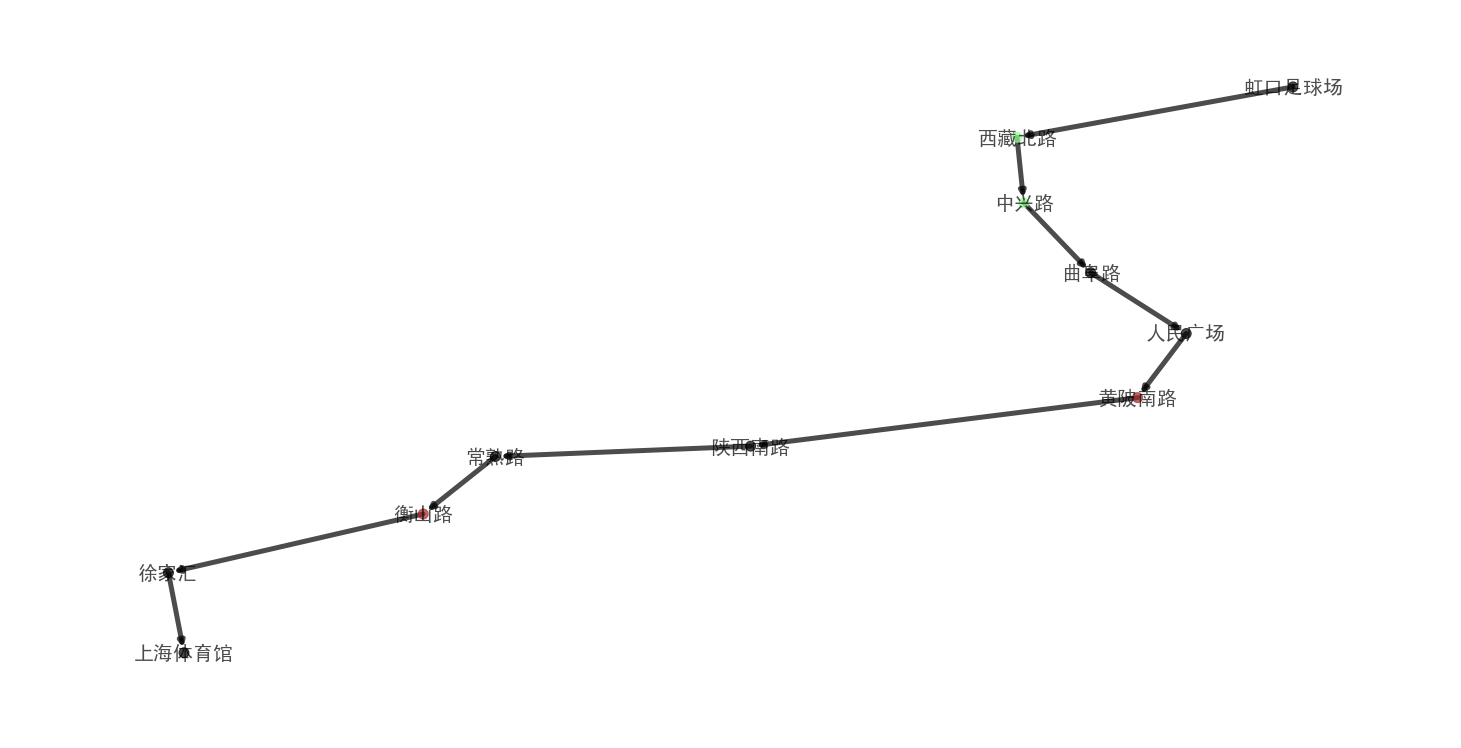

In [45]:
print('Minimum statios:')
search_agent('虹口足球场', '上海体育馆', optimal_search, show_graph=False)
print()
print('Minimum transfers')
search_agent('虹口足球场', '上海体育馆', optimal_search, search_strategy=mini_transfer, show_graph=False)
print()
print('Minimum time cost')
search_agent('虹口足球场', '上海体育馆', optimal_search, search_strategy=mini_time)

#### strategy 3 ---> minimum time cost while taking transfer time into consideration

In [46]:
# minimum time cost strategy while taking transfer time into consideration
gap_time = 5 # min, average transfer time plus waiting time

def mini_time_2(paths):
    def time_of_path(path):
        total_time = 0
        for i in range(len(path)-1):
            total_time += time_cost(path[i], path[i+1])
            if i > 0 and not is_same_line(path[i-1], path[i+1]):
                total_time += gap_time
        return total_time
    return sorted(paths, key=time_of_path)

In [47]:
def best_path_test(st1, st2):
    print('Minimum statios:')
    search_agent(st1, st2, optimal_search, show_graph=False)
    print()
    print('Minimum transfers')
    search_agent(st1, st2, optimal_search, search_strategy=mini_transfer, show_graph=False)
    print()
    print('Minimum time cost without transfer time cost')
    search_agent(st1, st2, optimal_search, search_strategy=mini_time, show_graph=False)
    print()
    print('Minimum time cost with transfer time cost')
    search_agent(st1, st2, optimal_search, search_strategy=mini_time_2)

Minimum statios:
The best path is 上海火车站->汉中路->南京西路->陕西南路->上海图书馆->交通大学->徐家汇

Minimum transfers
The best path is 上海火车站->汉中路->新闸路->人民广场->黄陂南路->陕西南路->常熟路->衡山路->徐家汇

Minimum time cost without transfer time cost
The best path is 上海火车站->汉中路->南京西路->陕西南路->常熟路->衡山路->徐家汇

Minimum time cost with transfer time cost
The best path is 上海火车站->汉中路->新闸路->人民广场->黄陂南路->陕西南路->常熟路->衡山路->徐家汇


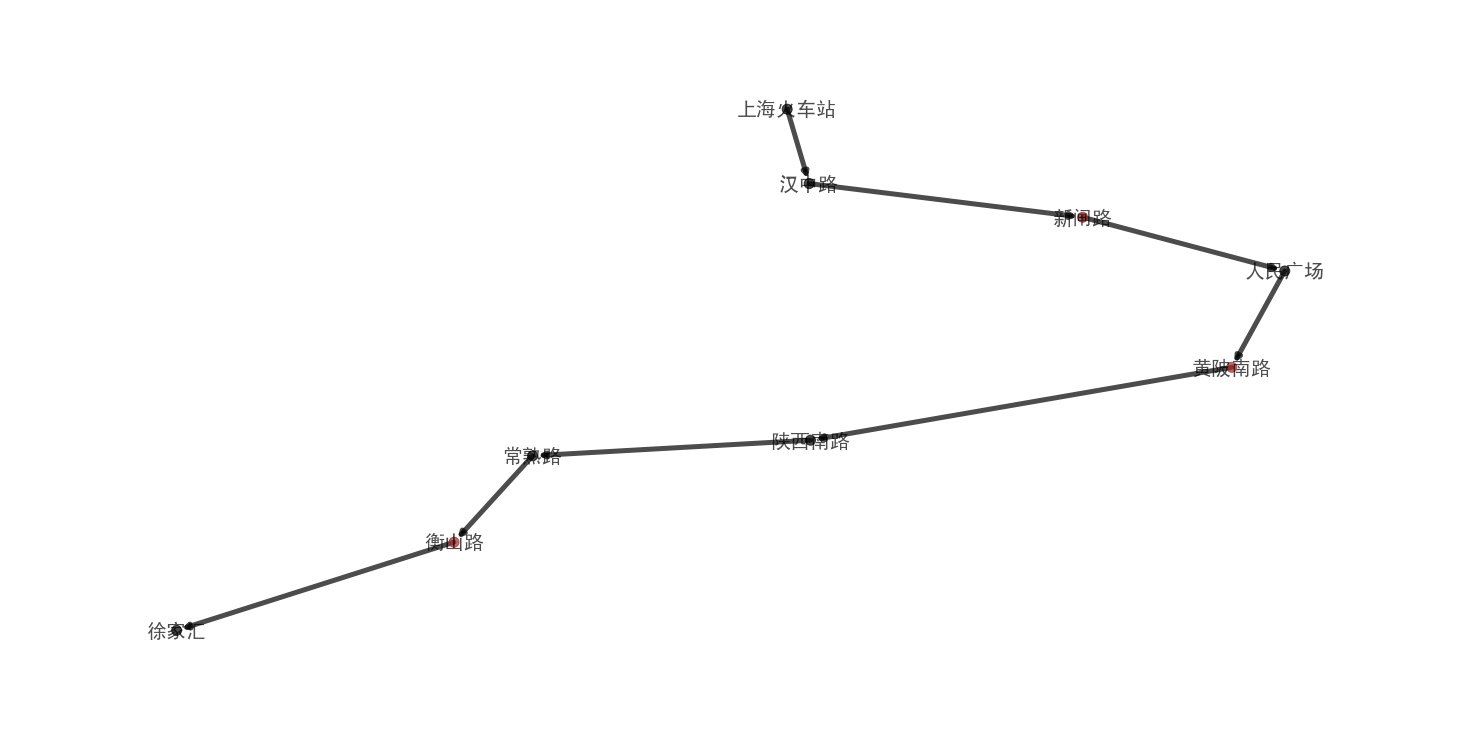

In [48]:
best_path_test('上海火车站', '徐家汇')

Minimum statios:
The best path is 虹口足球场->东宝兴路->宝山路->上海火车站->汉中路->南京西路->陕西南路->上海图书馆->交通大学->徐家汇->上海体育馆

Minimum transfers
The best path is 虹口足球场->西藏北路->中兴路->曲阜路->人民广场->南京西路->陕西南路->嘉善路->大木桥路->龙华中路->龙华->龙漕路->漕宝路->上海体育馆

Minimum time cost without transfer time cost
The best path is 虹口足球场->西藏北路->中兴路->曲阜路->人民广场->黄陂南路->陕西南路->常熟路->衡山路->徐家汇->上海体育馆

Minimum time cost with transfer time cost
The best path is 虹口足球场->西藏北路->中兴路->曲阜路->人民广场->南京西路->陕西南路->常熟路->衡山路->徐家汇->上海体育馆


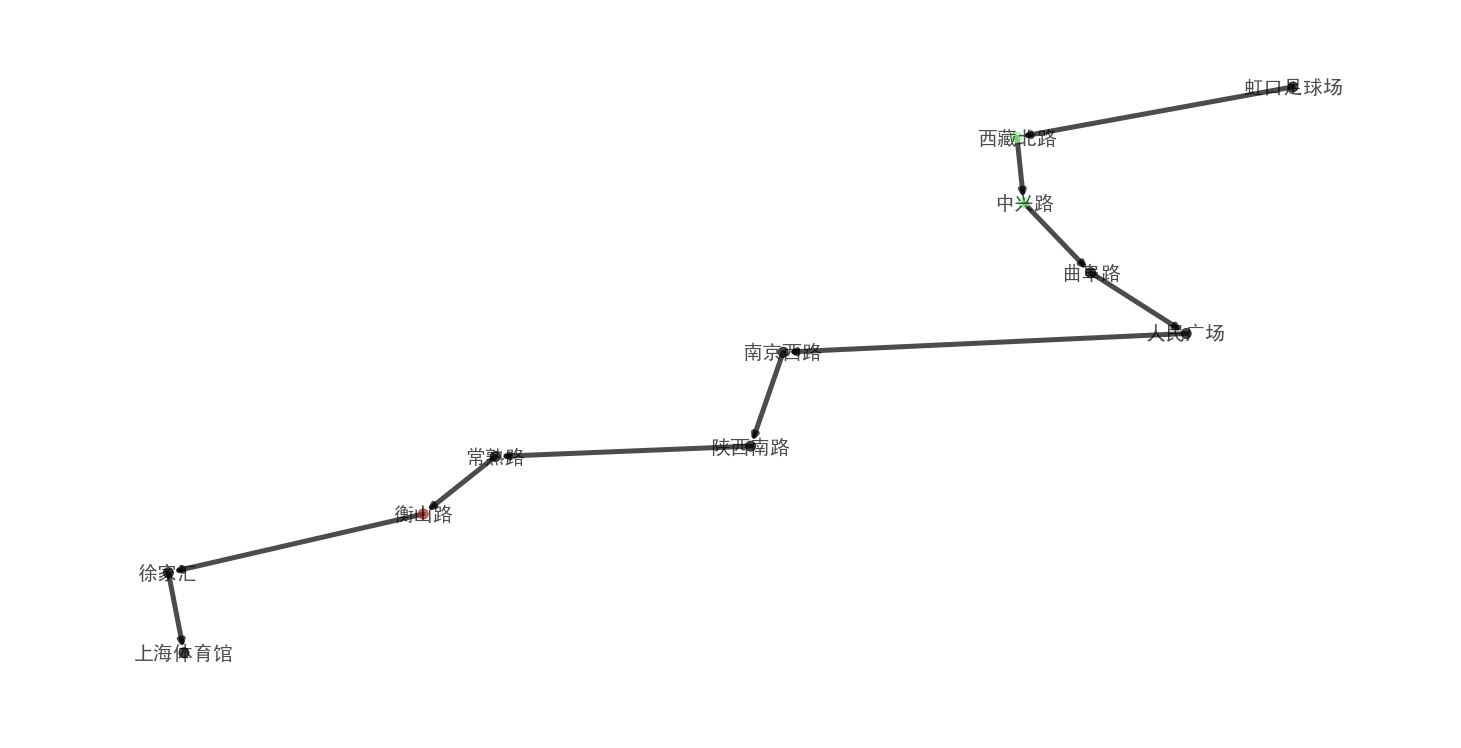

In [49]:
best_path_test('虹口足球场', '上海体育馆')

#### 简单自我评价一下

上面测试了2次路经，分别为【上海火车站--->徐家汇】和【虹口足球场--->上海体育馆】

百度地图显示的最快路经都和第四种策略Minimum time cost with transfer time cost一致。说明模型基本上没有太大的问题，能提升的地方主要在于数据层面
- 这里计算站与站之间的花费时间是用的直线距离/平均车速，如果能有站与站之间的历史平均耗时，模型可以更加准确
- 换乘时间可以更加精确。一般的地图都是通过步行距离来估计换乘时间，再加上实时的地铁位置估算地铁等待时间，肯定会更加精确
- 其实这次作业花费时间最多的地方在于看networkx源代码。本来最后是想把4种策略下的路径图用不同的颜色画在同一张图上，但是这样的话又要重构之前的代码，而且看文字也能足够清晰的分辨不同，就不再花时间了
- 写完整个代码后，其实有很多地方可以重构。比如说，从json文件提取stations数据和lines数据的时候，完全可以直接在stations里标注单个station是不是换乘站，有哪几个lines包括了这个station，只返回stations一个字典就够了，这样的话整个代码或许可以稍微干净一点。
- IDDFS

## Congratulations ! You have finished the assignment of week 2.

![title](img/agent.png)

### If you have any suggestions regarding the teaching, please feel free to send them to my eamil (eric.lee.xiao@gmail.com) 